# Creating MSTL residuals

In [41]:
library(forecast)
library(ggplot2)
library(dplyr)
library(data.table)
library(progress)
library(IRdisplay)

In [39]:
# Custom display function for the first and last 5 rows
display_limited <- function(dt) {
  # Concatenate the first 5 and last 5 rows
  limited_dt <- rbind(head(dt, 5), as.list(rep("...", ncol(dt))), tail(dt, 5))
  
  # Generate raw HTML manually
  html_output <- paste0(
    "<table border='1' style='border-collapse:collapse;'>",
    "<thead><tr>",
    paste0("<th>", colnames(limited_dt), "</th>", collapse = ""),
    "</tr></thead>",
    "<tbody>",
    paste0(
      apply(limited_dt, 1, function(row) {
        paste0("<tr>", paste0("<td>", row, "</td>", collapse = ""), "</tr>")
      }),
      collapse = ""
    ),
    "</tbody></table>"
  )
  
  # Display the HTML in the Jupyter notebook
  display_html(html_output)
}

In [40]:
base_path <- "C:/Users/madsh/OneDrive/Dokumenter/kandidat/Fællesmappe/Forecasting-energy-consumption/Data Cleaning"
setwd(base_path)

data <- fread(paste0(base_path,"/Output_file.csv"))
data <- data[,.(HourDK,GrossConsumptionMWh)]

# Use the display_limited function
display_limited(data)

HourDK,GrossConsumptionMWh
2020-01-01 00:00:00,3331.34729
2020-01-01 01:00:00,3257.505005
2020-01-01 02:00:00,3161.865601
2020-01-01 03:00:00,3074.752442
2020-01-01 04:00:00,3009.696167
...,...
2022-12-31 19:00:00,4453.29764833333
2022-12-31 20:00:00,4245.987671
2022-12-31 21:00:00,4092.87101266667
2022-12-31 22:00:00,3918.75976566667


In [64]:
# Initialize an empty data frame to store metrics for all individuals
MSTL_results <- data.frame()
X_t <- data

# Creating multi time series (y_t)
Y_t <- data[,"GrossConsumptionMWh"]
Y_t_ts <- msts(Y_t, seasonal.periods = c(24, 24*7, 24*365))

  # Using MSTL to find residuals, R_t
mstl_decomp <- mstl(Y_t_ts, lambda = NULL, iterate = 10000, s.window = c(24, 24*7, 24*365))
mstl_decomp_DT <- as.data.table(mstl_decomp)
X_t$Trend        <- mstl_decomp_DT$Trend
X_t$Seasonal24   <- mstl_decomp_DT$Seasonal24
X_t$Seasonal168  <- mstl_decomp_DT$Seasonal168
X_t$Seasonal8760 <- mstl_decomp_DT$Seasonal8760
X_t$Remainder    <- mstl_decomp_DT$Remainder
mstl_decomp_DT <- as.data.table(X_t)

In [66]:
summary(mstl_decomp_DT[,.(Trend, Seasonal24, Seasonal168, Seasonal8760, Remainder)])

     Trend        Seasonal24          Seasonal168          Seasonal8760     
 Min.   :3855   Min.   :-2742.7232   Min.   :-1026.4205   Min.   :-2540.88  
 1st Qu.:3987   1st Qu.: -288.8050   1st Qu.: -376.4831   1st Qu.:-1038.42  
 Median :4093   Median :  124.3271   Median :   27.5075   Median :   -6.13  
 Mean   :4069   Mean   :   -0.0361   Mean   :    0.0745   Mean   :    0.02  
 3rd Qu.:4158   3rd Qu.:  396.5389   3rd Qu.:  358.6759   3rd Qu.:  946.49  
 Max.   :4189   Max.   : 2125.8555   Max.   : 1046.2559   Max.   : 3200.56  
   Remainder        
 Min.   :-1181.656  
 1st Qu.:  -88.054  
 Median :    6.924  
 Mean   :    8.765  
 3rd Qu.:  104.141  
 Max.   : 2049.222  

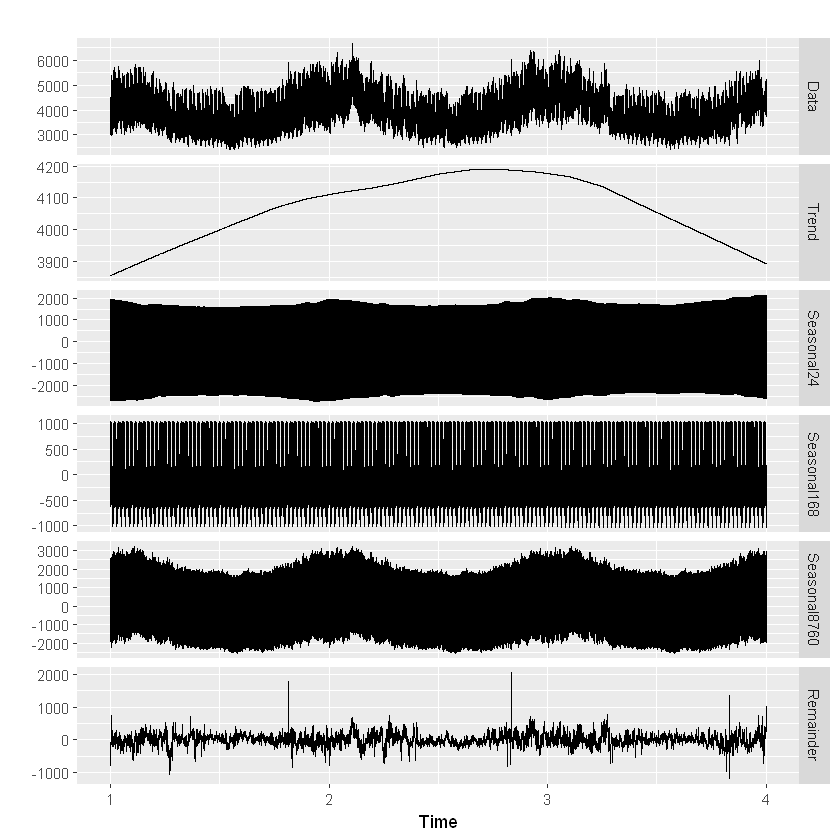

In [68]:
mstl_decomp %>% autoplot()

In [70]:
mstl_decomp_DT$Null_Remainder = 0

In [71]:
display_limited(mstl_decomp_DT)

HourDK,GrossConsumptionMWh,Trend,Seasonal24,Seasonal168,Seasonal8760,Remainder,Null_Remainder
2020-01-01 00:00:00,3331.34729,3854.59943598943,1932.72744572469,-380.09423037143,-1961.37245041428,-114.512910928375,0
2020-01-01 01:00:00,3257.505005,3854.63388465679,806.802040827772,101.235004882895,-1424.08063570018,-81.0852896672445,0
2020-01-01 02:00:00,3161.865601,3854.66833332415,507.664632452534,182.520404552462,-1283.62904830438,-99.3587210247915,0
2020-01-01 03:00:00,3074.752442,3854.70278199151,194.770180894927,301.679930697139,-1139.44387268007,-136.956578903527,0
2020-01-01 04:00:00,3009.696167,3854.73723065887,362.767817543067,233.650638191549,-1210.42919703625,-231.030322357232,0
...,...,...,...,...,...,...,...
2022-12-31 19:00:00,4453.29764833333,3891.3997996449,-250.524063623803,-980.659051528486,1179.49347193987,613.587491900859,0
2022-12-31 20:00:00,4245.987671,3891.3624570101,-541.772298052867,-1026.42049205803,1376.78958406269,546.028420038027,0
2022-12-31 21:00:00,4092.87101266667,3891.3250967521,-1503.9974115721,-726.880227033727,1925.57924045415,506.84431406618,0
2022-12-31 22:00:00,3918.75976566667,3891.2877364941,-2115.96038301778,-562.73679742292,2237.20119715365,468.968012459578,0


In [72]:
fwrite(mstl_decomp_DT, "MSTL_decomp_results.csv")